In [1]:
import alpdesign
import numpy as np
import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from jax.experimental import optimizers
import importlib
importlib.reload(alpdesign)

<module 'alpdesign' from '/mnt/c/Users/white/repos/ALP-Design/alpdesign/__init__.py'>

### Initialize data

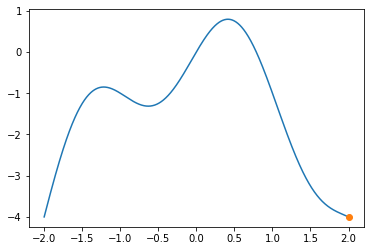

In [2]:
key = jax.random.PRNGKey(0)
x = np.linspace(-2,2, 1000)
reps = np.array([2.0]).reshape(-1,1)
label_fxn = lambda x: np.sin(x * np.pi) - x ** 2
labels = label_fxn(reps)
plt.plot(x,  label_fxn(x))
plt.plot(reps, labels, 'o')

In [3]:
config = alpdesign.EnsembleBlockConfig(shape=(32, 16, 2), model_number=3)
aconfig = alpdesign.AlgConfig(train_epochs=3, bo_epochs=5, bo_batch_size=2)
model_forward_t, full_model_forward_t, seq_model_t, model_uncertainty_eval_t = alpdesign.build_e2e(config)

In [4]:
#batch_size = 16
def loop(key, reps, params):
    labels = label_fxn(reps)
    key, key2 = jax.random.split(key)
    best_v, *_, params, train_loss, bo_loss = alpdesign.alg_iter(
        key2, reps, labels, full_model_forward_t, model_forward_t, config, aconfig
        )
    # compute plot
    yhat_mu, yhat_std = [], []
    eis = []
    # TODO: Why we need keys when training False??
    plot_forward = partial(model_forward_t.apply, params, training=False)
    for xi in x:
        v = plot_forward(key, xi[np.newaxis])
        yhat_mu.append(float(v[0]))
        yhat_std.append(jnp.sqrt(float(v[1])))
        ei = -alpdesign.mlp.neg_bayesian_ei(key, plot_forward, xi[np.newaxis], labels, 1e-1)
        eis.append(ei)
    # add new label
    plt.figure()
    plt.plot(x, eis)
    plt.title('Expected info')
    plt.show()
    plt.figure()
    plt.plot(train_loss)
    plt.title('Training Loss')
    plt.show()
    plt.figure()
    plt.plot(train_loss)
    plt.title('BO Loss')
    plt.show()
    reps = jnp.concatenate((reps, best_v[np.newaxis]))    
    return key, reps, yhat_mu, yhat_std, best_v, params
    
    

0


/home/whitead/miniconda3/envs/alp/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3176: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "zeros")


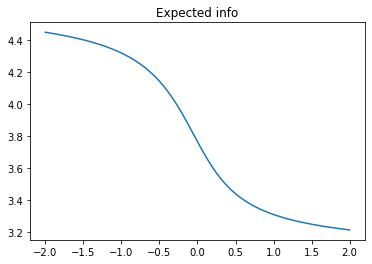

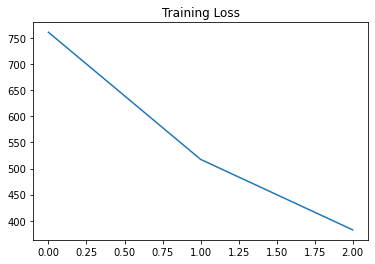

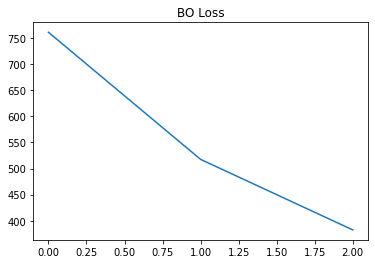

1


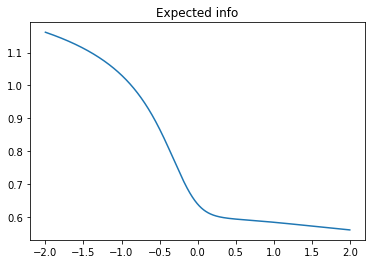

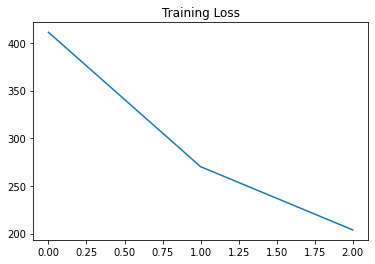

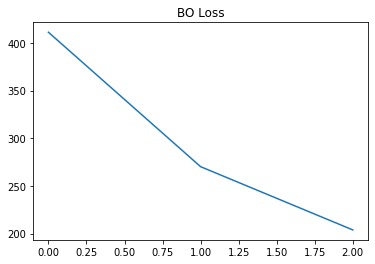

2


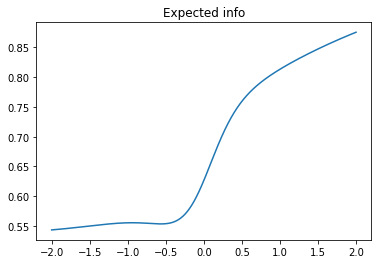

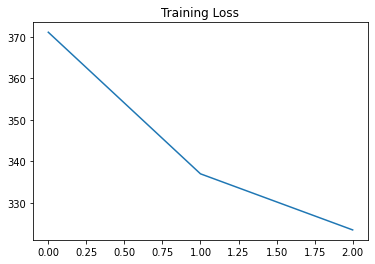

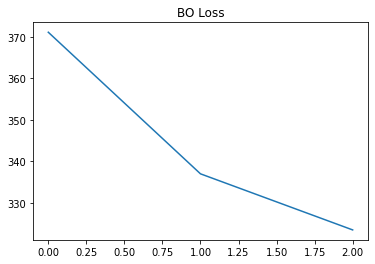

3


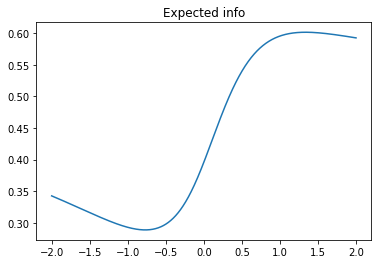

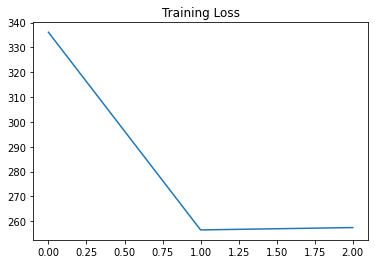

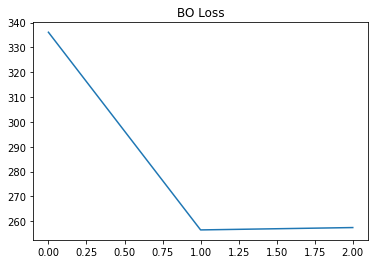

4


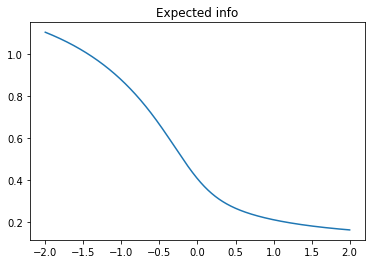

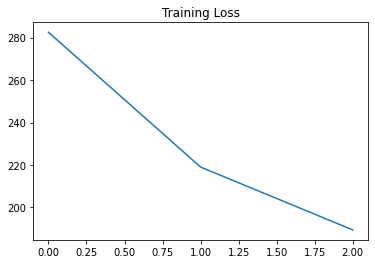

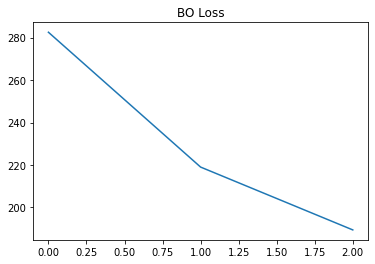

In [5]:
key = jax.random.PRNGKey(0)
T = 5

yhat_mus = []
yhat_stds = []
final_vecs = []
repss = []
params = None
for i in range(T):
    print(i)
    key, reps, yhat_mu, yhat_std, final_vec, params= loop(key, reps, params)
    yhat_mus.append(yhat_mu)
    yhat_stds.append(yhat_std)
    final_vecs.append(final_vec)
    repss.append(reps)
    

0
1
2
3
4


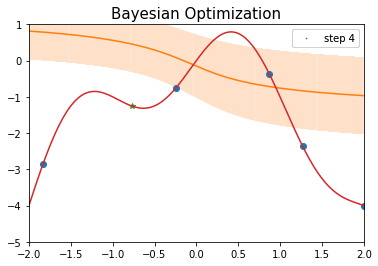

In [6]:
from celluloid import Camera
fig = plt.figure()
camera = Camera(fig)

for i in range(T):
    plt.plot(np.squeeze(repss[i][:-1]), label_fxn(np.squeeze(repss[i][:-1])), 'o', color='C0')
    plt.plot(x, yhat_mus[i], color='C1')
    plt.xlim(-2,2)
    #print(x.shape)
    #print()
    print(i)
    plt.ylim([-5, 1])
    plt.plot(final_vecs[i][0], label_fxn(final_vecs[i][0]), '*', color='C2')
    plt.plot(x, label_fxn(x), color='C3')
    plt.errorbar(x, yhat_mus[i], yerr=yhat_stds[i], color='C1', alpha=0.05)
    plt.legend(['step %d' % (i)] , markerscale=0.1)
    plt.title('Bayesian Optimization', fontsize=15)
    camera.snap()
animation = camera.animate(interval = 2000, repeat = True,
                           repeat_delay = 500)
animation.save('BO_newloss.gif', writer = 'imagemagick', dpi=180)